# 영업부 요청사항 분석 -> 제품 추천 -> 이메일 초안생성 Multi Agent(feat. LangGraph)

## 목표
이번 실습에서는 LangGraph를 활용하여 Multi-Agent System을 구축합니다.
KT 영업부의 업무를 자동화하는 시나리오를 통해 다음을 학습합니다:

1. **개별 Agent 설계**: React Agent를 활용한 전문화된 Agent 구성
2. **Multi-Agent Pattern 선택**: 시나리오에 적합한 패턴 선택과 이유
3. **StateGraph 설계**: 복잡한 상태 관리를 위한 전략적 설계

## 시나리오
KT 영업부에서 요청을 받아 분석하고, 적절한 제품을 추천한 후, 이메일 초안을 생성하는 프로세스를 자동화합니다.

### 업무 흐름
1. **요청 분석**: 영업부의 요구사항 분석 및 핵심 needs 파악
2. **제품 추천**: 분석된 요구사항에 맞는 KT 제품/서비스 추천
3. **이메일 작성**: 추천 내용을 바탕으로 영업부와의 소통을 위한 맞춤형 이메일 초안 생성

In [5]:
import os
import json
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from datetime import datetime
import operator

# LangChain imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings, AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# Vector store imports
from langchain_chroma import Chroma
from langchain_community.vectorstores.azuresearch import AzureSearch

from dotenv import load_dotenv
load_dotenv()

True

In [6]:
# 환경 선택 (강사용: "local", 수강생용: "azure")
ENVIRONMENT = "local"  # 또는 "azure"

if ENVIRONMENT == "local":
    # 강사용 설정
    llm = ChatOpenAI(
        model="gpt-4o",
        temperature=0
    )
    embeddings = OpenAIEmbeddings(
        model="text-embedding-3-small"
    )
    # 강사용 벡터 스토어
    vector_store = Chroma(
        persist_directory="./kt_products_index",
        embedding_function=embeddings,
        collection_name="kt_products"
    )
else:
    # 수강생용 Azure 설정
    llm = AzureChatOpenAI(
        azure_deployment="gpt-4o",
        api_version="2024-02-01",
        temperature=0
    )
    embeddings = AzureOpenAIEmbeddings(
        azure_deployment="text-embedding-3-small",
        openai_api_version="2024-02-01"
    )
    # Azure AI Search
    vector_store = AzureSearch(
        azure_search_endpoint=f"https://{os.environ['AZURE_AI_SEARCH_SERVICE_NAME']}.search.windows.net",
        azure_search_key=os.environ["AZURE_AI_SEARCH_API_KEY"],
        index_name="kt-products-index",
        embedding_function=embeddings
    )

print(f"Environment: {ENVIRONMENT}")
print(f"Model: {llm.model_name if hasattr(llm, 'model_name') else 'Configured'}")

Environment: local
Model: gpt-4o


In [7]:
# KT 제품 및 서비스 Mock 데이터
KT_PRODUCTS = [
    {
        "name": "KT 기가 인터넷",
        "category": "인터넷",
        "speed": "10Gbps",
        "price": "월 55,000원",
        "features": ["초고속 인터넷", "안정적인 연결", "24시간 고객지원"],
        "target": "대용량 데이터 사용 기업, 게임/스트리밍 업체"
    },
    {
        "name": "KT 클라우드 서버",
        "category": "클라우드",
        "specs": "vCPU 8core, RAM 32GB, SSD 1TB",
        "price": "월 350,000원부터",
        "features": ["99.9% 가동률 보장", "자동 백업", "DDoS 방어"],
        "target": "중소기업, 스타트업, 개발 팀"
    },
    {
        "name": "KT 비즈 콜센터",
        "category": "통신 솔루션",
        "channels": "음성, 채팅, 이메일 통합",
        "price": "월 500,000원부터",
        "features": ["AI 상담 봇", "실시간 모니터링", "통계 분석"],
        "target": "고객센터 운영 기업, 서비스업"
    },
    {
        "name": "KT AI 스피커 기가지니",
        "category": "AI 솔루션",
        "features": ["음성 인식", "스마트홈 연동", "업무 자동화"],
        "price": "월 30,000원",
        "target": "스마트 오피스, 호텔, 병원"
    }
]

# 제품 데이터를 문자열로 변환 (검색용)
PRODUCTS_TEXT = "\n\n".join([
    f"제품명: {p['name']}\n카테고리: {p['category']}\n특징: {', '.join(p['features'])}\n가격: {p['price']}\n타겟: {p['target']}"
    for p in KT_PRODUCTS
])

print("KT 제품 데이터 준비 완료")
print(f"총 {len(KT_PRODUCTS)}개 제품 로드됨")

KT 제품 데이터 준비 완료
총 4개 제품 로드됨


### Agent를 위한 도구(Tools) 정의

각 Agent가 사용할 수 있는 도구들을 정의합니다.

In [8]:
@tool
def search_kt_products(query: str) -> str:
    """KT 제품 데이터베이스에서 관련 제품을 검색합니다.

    Args:
        query: 검색할 키워드 또는 요구사항

    Returns:
        관련 제품 정보
    """
    # 실제로는 vector_store.similarity_search()를 사용
    # 여기서는 간단한 키워드 매칭으로 구현
    results = []
    for product in KT_PRODUCTS:
        if any(keyword.lower() in str(product).lower()
               for keyword in query.split()):
            results.append(product)

    if results:
        return json.dumps(results, ensure_ascii=False, indent=2)
    else:
        return "관련 제품을 찾을 수 없습니다."

@tool
def calculate_pricing(products: List[str], quantity: int = 1, months: int = 12) -> str:
    """선택된 제품들의 예상 비용을 계산합니다.

    Args:
        products: 제품명 리스트
        quantity: 수량
        months: 계약 기간(월)

    Returns:
        가격 계산 결과
    """
    total = 0
    breakdown = []

    for product_name in products:
        for product in KT_PRODUCTS:
            if product["name"] == product_name:
                # 가격 파싱 (간단한 예제)
                price_str = product["price"]
                if "부터" in price_str:
                    price = int(price_str.replace("월 ", "").replace(",", "").replace("원부터", ""))
                else:
                    price = int(price_str.replace("월 ", "").replace(",", "").replace("원", ""))

                subtotal = price * quantity * months
                total += subtotal
                breakdown.append(f"{product_name}: {price:,}원 x {quantity}개 x {months}개월 = {subtotal:,}원")

    result = f"총 예상 비용: {total:,}원\n내역:\n" + "\n".join(breakdown)
    return result

@tool
def get_customer_template(customer_type: str) -> str:
    """고객 유형에 맞는 이메일 템플릿을 가져옵니다.

    Args:
        customer_type: 고객 유형 (startup, enterprise, government 등)

    Returns:
        이메일 템플릿
    """
    templates = {
        "startup": "안녕하세요, {company_name} 대표님. 스타트업의 성장을 위한 KT의 특별한 제안을 준비했습니다.",
        "enterprise": "{company_name} 담당자님, 안녕하세요. 귀사의 디지털 혁신을 위한 KT의 엔터프라이즈 솔루션을 소개드립니다.",
        "government": "안녕하세요. 공공기관의 효율적인 운영을 위한 KT의 검증된 솔루션을 제안드립니다.",
        "default": "안녕하세요, {company_name}님. KT의 최적화된 솔루션을 소개드립니다."
    }
    return templates.get(customer_type, templates["default"])

print("Agent 도구 정의 완료")

Agent 도구 정의 완료


## 1. 요청사항 분석 Agent

In [11]:
# 1. Request Analyzer Agent
request_analyzer_prompt = """당신은 KT 영업부의 고객 요청 분석 전문가입니다.

주요 업무:
1. 고객의 요청사항을 분석하여 핵심 needs를 파악합니다.
2. 기업 규모, 업종, 기술 수준을 파악합니다.
3. 예산 범위와 시급성을 확인합니다.
4. 현재 사용 중인 서비스와 pain point를 식별합니다.

분석 결과는 다음 형식으로 정리해주세요:
- 고객 유형: (startup/enterprise/government/etc)
- 핵심 요구사항: [리스트]
- 예산 규모: (추정치)
- 우선순위: (높음/중간/낮음)
- 추천 카테고리: [관련 제품 카테고리]
"""

request_analyzer = create_react_agent(
    model=llm,
    tools=[search_kt_products],
    state_modifier=request_analyzer_prompt,
)

## 2. 제품 추천 Agent

In [13]:
# 2. Product Recommender Agent
product_recommender_prompt = """당신은 KT 제품 추천 전문가입니다.

주요 업무:
1. 분석된 고객 요구사항에 가장 적합한 KT 제품/서비스를 추천합니다.
2. 제품 조합(번들)을 고려하여 시너지 효과를 극대화합니다.
3. 비용 대비 효과를 분석하여 최적의 솔루션을 제안합니다.
4. 경쟁사 대비 KT의 강점을 부각시킵니다.

추천 시 고려사항:
- 고객의 기술 수준과 인프라
- 확장 가능성
- 총소유비용(TCO)
- 구현 난이도

항상 제품 검색 도구를 사용하여 최신 정보를 확인하세요.
"""

product_recommender = create_react_agent(
    model=llm,
    tools=[search_kt_products, calculate_pricing],
    state_modifier=product_recommender_prompt,
)

## 3. 이메일 초안 생성 Agent

In [15]:
# 3. Email Composer Agent
email_composer_prompt = """당신은 KT 영업부의 이메일 작성 전문가입니다.

주요 업무:
1. 고객 맞춤형 제안 이메일을 작성합니다.
2. 전문적이면서도 친근한 톤을 유지합니다.
3. 제품의 가치를 명확히 전달합니다.
4. Call-to-Action을 명확히 제시합니다.

이메일 구성:
1. 인사말 (고객 유형에 맞춘 템플릿 사용)
2. 고객의 needs 요약
3. 추천 솔루션 소개
4. 핵심 이점 3가지
5. 가격 정보 (필요시)
6. 다음 단계 제안
7. 맺음말

한국 비즈니스 문화에 맞는 정중한 표현을 사용하세요.
"""

email_composer = create_react_agent(
    model=llm,
    tools=[get_customer_template],
    state_modifier=email_composer_prompt,
)

## 4. Multi-Agent 로 만들기

✅ Multi-Agent Workflow Graph 구성 및 컴파일 완료


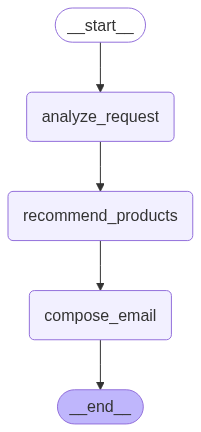

In [17]:
class MultiAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]  # 메시지 히스토리
    customer_request: str                                  # 원본 요청
    analysis_result: Optional[Dict[str, Any]]             # 분석 결과
    recommended_products: Optional[List[Dict[str, Any]]]  # 추천 제품
    pricing_info: Optional[str]                           # 가격 정보
    email_draft: Optional[str]                            # 이메일 초안
    process_metadata: Annotated[Dict[str, Any], operator.or_]  # 메타데이터
    errors: Annotated[List[str], operator.add]           # 에러 추적


# Agent Node 함수 정의 - 실제 Agent를 호출하도록 수정
def analyze_request(state: MultiAgentState) -> Dict[str, Any]:
    """요청 분석 Agent 실행"""
    print("🔍 요청 분석 시작...")

    # Request Analyzer Agent 실행
    result = request_analyzer.invoke({
        "messages": [
            HumanMessage(content=f"다음 고객 요청을 분석해주세요: {state['customer_request']}")
        ]
    })

    # Agent의 응답에서 분석 결과 추출
    last_message = result["messages"][-1].content

    # 분석 결과 파싱 (실제로는 구조화된 출력을 사용하는 것이 좋음)
    import re

    analysis = {
        "customer_type": "enterprise" if "기업" in last_message or "enterprise" in last_message else "startup",
        "needs": re.findall(r'요구사항[:\s]*([^\n]+)', last_message),
        "budget": re.search(r'예산[:\s]*([^\n]+)', last_message),
        "priority": "높음" if "시급" in last_message or "urgent" in last_message else "중간"
    }

    return {
        "messages": result["messages"],
        "analysis_result": analysis,
        "process_metadata": {
            "analyze_request_completed": datetime.now().isoformat()
        }
    }

def recommend_products(state: MultiAgentState) -> Dict[str, Any]:
    """제품 추천 Agent 실행"""
    print("📦 제품 추천 시작...")

    # 이전 분석 결과를 바탕으로 추천
    analysis = state.get("analysis_result", {})

    # Product Recommender Agent 실행
    result = product_recommender.invoke({
        "messages": [
            HumanMessage(content=f"""
            고객 분석 결과:
            - 고객 유형: {analysis.get('customer_type')}
            - 핵심 요구사항: {analysis.get('needs')}
            - 예산: {analysis.get('budget')}

            가장 적합한 KT 제품을 추천하고 가격을 계산해주세요.
            """)
        ]
    })

    # 추천 결과에서 제품 정보 추출
    last_message = result["messages"][-1].content

    # Tool call이 있었다면 그 결과도 포함
    tool_messages = [msg for msg in result["messages"] if hasattr(msg, 'name')]

    recommendations = []
    pricing_info = ""

    # Tool 결과에서 제품 정보 추출
    for msg in tool_messages:
        if msg.name == "search_kt_products" and msg.content:
            try:
                products = json.loads(msg.content)
                if isinstance(products, list):
                    recommendations.extend([
                        {"name": p["name"], "reason": f"{p['category']} - {', '.join(p['features'][:2])}"}
                        for p in products[:2]  # 상위 2개만
                    ])
            except:
                pass
        elif msg.name == "calculate_pricing" and msg.content:
            pricing_info = msg.content

    return {
        "messages": result["messages"],
        "recommended_products": recommendations,
        "pricing_info": pricing_info,
        "process_metadata": {
            "recommend_products_completed": datetime.now().isoformat()
        }
    }

def compose_email(state: MultiAgentState) -> Dict[str, Any]:
    """이메일 작성 Agent 실행"""
    print("✉️ 이메일 작성 시작...")

    # 이전 단계들의 정보를 종합
    analysis = state.get("analysis_result", {})
    products = state.get("recommended_products", [])
    pricing = state.get("pricing_info", "")

    # Email Composer Agent 실행
    result = email_composer.invoke({
        "messages": [
            HumanMessage(content=f"""
            다음 정보를 바탕으로 고객에게 보낼 이메일을 작성해주세요:

            원본 고객 요청:
            {state['customer_request']}

            고객 정보:
            - 유형: {analysis.get('customer_type')}
            - 요구사항: {analysis.get('needs')}

            추천 제품:
            {json.dumps(products, ensure_ascii=False, indent=2)}

            가격 정보: {pricing}
            """)
        ]
    })

    # 이메일 내용 추출
    email_content = result["messages"][-1].content

    # 템플릿이 사용되었다면 그것도 포함
    template_msg = next((msg for msg in result["messages"] if hasattr(msg, 'name') and msg.name == "get_customer_template"), None)
    if template_msg:
        # 템플릿을 기반으로 이메일 개선
        pass

    return {
        "messages": result["messages"],
        "email_draft": email_content,
        "process_metadata": {
            "compose_email_completed": datetime.now().isoformat(),
            "total_messages": len(state.get("messages", []) + result["messages"])
        }
    }

# StateGraph 생성 및 구성
def build_multi_agent_graph():
    """Multi-Agent Workflow Graph 구성"""

    # StateGraph 초기화
    workflow = StateGraph(MultiAgentState)

    # Node 추가 - 각 Agent를 Node로 등록
    workflow.add_node("analyze_request", analyze_request)
    workflow.add_node("recommend_products", recommend_products)
    workflow.add_node("compose_email", compose_email)

    # Edge 정의 - Sequential Flow 구성
    # START -> analyze_request
    workflow.add_edge(START, "analyze_request")

    # analyze_request -> recommend_products
    workflow.add_edge("analyze_request", "recommend_products")

    # recommend_products -> compose_email
    workflow.add_edge("recommend_products", "compose_email")

    # compose_email -> END
    workflow.add_edge("compose_email", END)

    # Checkpointer 추가 (상태 저장을 위해)
    checkpointer = MemorySaver()

    # Graph 컴파일 - 실행 가능한 앱으로 변환
    app = workflow.compile(checkpointer=checkpointer)

    return app

# Multi-Agent System 생성
multi_agent_app = build_multi_agent_graph()

# Graph 시각화
from IPython.display import Image, display
display(Image(multi_agent_app.get_graph().draw_mermaid_png()))